In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import os, sys, re, glob, time, pickle, IPython, logging
import scipy.ndimage as ndi
from itertools import islice
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset
from ocrlib import ocrhelpers as helpers
from ocrlib.ocrhelpers import *
from ocrlib import ocrmodels as models
RUN("date"); RUN("hostname"); RUN("whoami"); RUN("nvidia-smi -L")

charset = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_str(s): 
    return [charset.find(c)+1 for c in s]

def decode_str(l): 
    return "".join([charset[k-1] for k in l])

transforms = [
    lambda x: (torch.tensor(x).float()/255.0).unsqueeze(0),
    lambda s: torch.tensor(encode_str(s)).long()
]
training = WebDataset("data/words-simple-training.tar", decoder="l8", 
                      extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
testing = WebDataset("data/words-simple-test.tar", decoder="l8", 
                     extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
training_dl = DataLoader(training, batch_size=5, collate_fn=helpers.collate4ocr)
testing_dl = DataLoader(testing, batch_size=20, collate_fn=helpers.collate4ocr)
next(iter(training_dl))[0].size()

date : Tue Oct  1 15:23:11 PDT 2019
hostname : sedna
whoami : tmb
nvidia-smi -L : GPU 0: GeForce GTX 1080 Ti (UUID: GPU-2d5cf167-db75-89ec-c6f7-5639237768ce)


torch.Size([5, 1, 96, 496])

In [3]:
!awk '/conv_resnet/' RS="\n\n" ocrlib/ocrmodels.py

def make_conv_resnet(noutput=noutput):
    model = nn.Sequential(
        layers.Input("BDHW", range=(0, 1), sizes=[None, 1, None, None]),
        *combos.conv2d_block(64, 3, mp=2),
        *combos.resnet_blocks(5, 64),
        *combos.conv2d_block(128, 3, mp=(2, 1)),
        *combos.resnet_blocks(5, 128),
        *combos.conv2d_block(192, 3, mp=2),
        *combos.resnet_blocks(5, 192),
        *combos.conv2d_block(256, 3, mp=(2, 1)),
        *combos.resnet_blocks(5, 256),
        *combos.conv2d_block(512, 3),
        *project_and_conv1d(512, noutput)
    )
    flex.shape_inference(model, (1, 1, 128, 512))
    return model


In [4]:
model = models.make("conv_resnet")

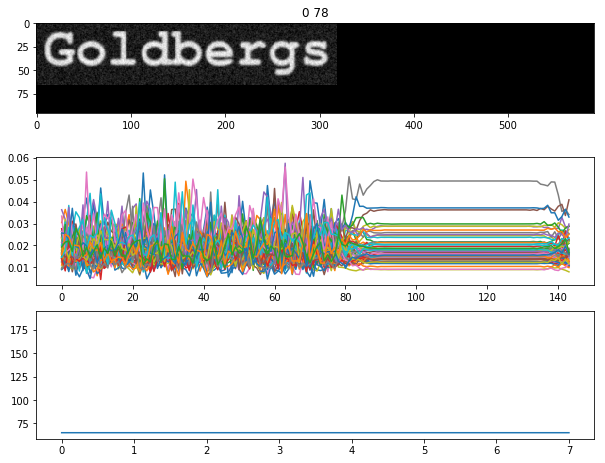

In [5]:
trainer = helpers.LineTrainer(model)
trainer.train(training_dl, 10, every=10)

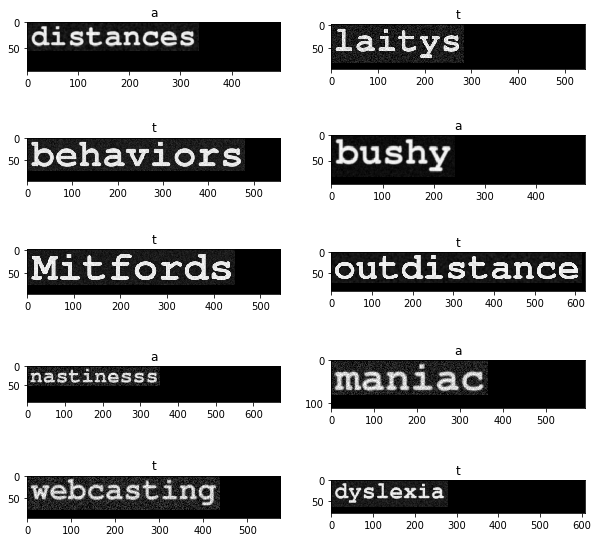

In [6]:
figsize(10, 10)
for i, batch in enumerate(islice(training_dl, 0, 10)):
    subplot(5, 2, i+1)
    result = trainer.predict_batch(*batch[:2], threshold=0.8)
    imshow(batch[0][0,0].detach().numpy())
    title(decode_str(result[0]))

In [7]:
trainer.errors(testing_dl)

(102, 111)